<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_rk4_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RK4Solver

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=966027fbc38ef555b5ab163a1b87a8e032c9ebbb7989638ad4d01a8da38ca9ac
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.6 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=a9e30e4cc17a9df34dca5debc6ece6d0bd816846c541c0fe699e864e61b0d799
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn


In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
# from torchdyn.numerics.solvers import SolverTemplate

In [4]:
#@title solver 
class SolverTemplate(nn.Module):
    def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
        super().__init__()
        self.order = order
        self.min_factor = torch.tensor([min_factor])
        self.max_factor = torch.tensor([max_factor])
        self.safety = torch.tensor([safety])
        self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        if self.tableau is not None:
            c, a, bsol, berr = self.tableau
            self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
                proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        self.safety = self.safety.to(device)
        self.min_factor = self.min_factor.to(device)
        self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass

class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        super().__init__(order=1)
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

In [5]:
#@title bioreactor model
def inhibition_model(t, x):
    b = x[:, 0]
    s = x[:, 1]
    p = x[:, 2]

    # Kinetic parameters
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # Mass balances
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

In [6]:
def create_initial_cond(n_training,
                         lower_limit_x,
                         upper_limit_x,
                         lower_limit_s,
                         upper_limit_s,
                         lower_limit_p,
                         upper_limit_p):
    
    x0_train = (
        torch.tensor(lhs(3, n_training), device='cpu') 
    ) 
    x0_train[:,0] = x0_train[:,0] * upper_limit_x + lower_limit_x # biomass (0.2-10.2)
    x0_train[:,1] = x0_train[:,1] * upper_limit_s + lower_limit_s # substrate (0-40)
    x0_train[:,2] = x0_train[:,2] * upper_limit_p + lower_limit_p # product (0-40)
    return x0_train 

In [7]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 10, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 7.1844, 27.7643, 37.9005],
        [ 0.6505,  4.7098, 21.8603],
        [ 8.6179, 12.6598, 23.3566],
        [ 6.8514, 28.4730, 31.9063],
        [10.1419, 38.8710, 14.3355]], dtype=torch.float64)
torch.Size([100, 3])


In [8]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 0.2, 10, 0, 40, 0, 40)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 6.0504, 18.3083, 21.5142],
        [ 0.5039, 14.7754, 26.8549],
        [ 9.1560, 26.4804,  8.0185],
        [ 1.5902, 30.1036, 18.8797],
        [ 7.7830, 22.4541, 31.9167]], dtype=torch.float64)
torch.Size([10, 3])


In [9]:
def create_time_span(start_time, end_time, step_size):
    ε = 1e-10 
    t_span = torch.arange(
        start_time, 
        end_time + ε,
        step_size
    )
    return t_span

In [10]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

In [11]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model, x0_train, t_span_train, solver="rk4")

In [12]:
# Function to plot trajectory
def plot_trajectory(n, trajectories):
    if n == 0:
        plt.plot(trajectories[:, n, 0], label='biomass', color="lightgreen")
        plt.plot(trajectories[:, n, 1], label='substrate', color="#F97306")
        plt.plot(trajectories[:, n, 2], label='product', color="#069AF3")
    else: 
        plt.plot(trajectories[:, n, 0], color="lightgreen")
        plt.plot(trajectories[:, n, 1], color="#F97306")
        plt.plot(trajectories[:, n, 2], color="#069AF3")


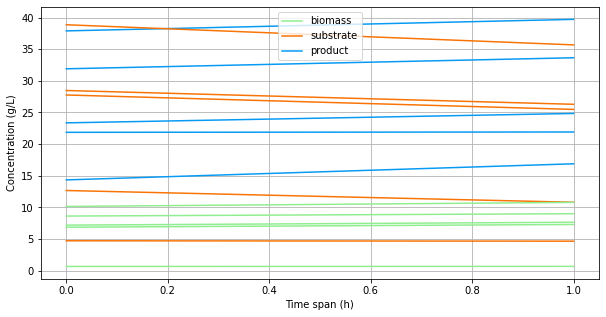

In [13]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

In [14]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model, x0_validate, t_span_validate, solver="rk4")

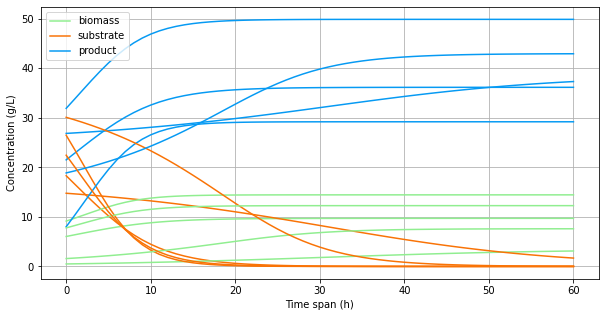

In [15]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

In [16]:
def fnn_model(input_dim, output_dim, hidden_dim, hidden_layers):
    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    for _ in range(hidden_layers):
        layers.append(nn.Linear(hidden_dim, hidden_dim)) 
        layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, output_dim))
    net = nn.Sequential(*layers) 
    net.to('cpu').double()

    for m in net.modules():
        if type(m) == nn.Linear:
            # Initialize the weights of the Linear module using xavier_uniform_
            nn.init.xavier_uniform_(m.weight)
    return net

In [20]:
# Create model
net = fnn_model(3, 3, 32, 8)

In [21]:
# training algorithm
optimizer = Adam(net.parameters()) 

In [22]:
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver='rk4'
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    net.eval()
    with torch.inference_mode():

        # 1. Forward pass
        _, x_pred_validate = odeint(
            lambda t, x: net(x), 
            x0_validate, 
            t_span_validate, 
            solver='rk4'
        )

        # 2. Calculate loss
        loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")


  0%|          | 2/2000 [00:00<02:54, 11.46it/s]

Epoch: 0 | Training loss: 0.44736899096427646 | Validate loss: 2374.361642472287


  3%|▎         | 52/2000 [00:04<02:47, 11.62it/s]

Epoch: 50 | Training loss: 0.005157599330134869 | Validate loss: 11.040387548814497


  5%|▌         | 102/2000 [00:11<04:35,  6.88it/s]

Epoch: 100 | Training loss: 0.000635677212926023 | Validate loss: 3.094488890686246


  8%|▊         | 152/2000 [00:16<02:40, 11.50it/s]

Epoch: 150 | Training loss: 0.000510893673376583 | Validate loss: 2.340862864348257


 10%|█         | 202/2000 [00:20<02:30, 11.98it/s]

Epoch: 200 | Training loss: 0.00033533751250638597 | Validate loss: 2.0828375816077664


 13%|█▎        | 252/2000 [00:24<02:26, 11.97it/s]

Epoch: 250 | Training loss: 0.0002628973367204407 | Validate loss: 1.7524071527590275


 15%|█▌        | 302/2000 [00:28<02:21, 12.01it/s]

Epoch: 300 | Training loss: 0.00023747212259529448 | Validate loss: 1.2167988452734342


 18%|█▊        | 352/2000 [00:32<02:17, 12.03it/s]

Epoch: 350 | Training loss: 0.0001770505914461113 | Validate loss: 0.8802099035330794


 20%|██        | 403/2000 [00:37<02:13, 11.94it/s]

Epoch: 400 | Training loss: 0.00015049284013558546 | Validate loss: 0.549812062442962


 23%|██▎       | 453/2000 [00:41<02:10, 11.88it/s]

Epoch: 450 | Training loss: 0.00011312863490120667 | Validate loss: 0.35347027842121526


 25%|██▌       | 503/2000 [00:46<02:07, 11.70it/s]

Epoch: 500 | Training loss: 0.0002615346181305946 | Validate loss: 0.20349918789394142


 28%|██▊       | 553/2000 [00:50<02:01, 11.94it/s]

Epoch: 550 | Training loss: 8.035909630686958e-05 | Validate loss: 0.14525383227639457


 30%|███       | 603/2000 [00:54<01:54, 12.18it/s]

Epoch: 600 | Training loss: 6.580800680002441e-05 | Validate loss: 0.09350087179930332


 33%|███▎      | 653/2000 [00:58<01:48, 12.41it/s]

Epoch: 650 | Training loss: 5.525519387074381e-05 | Validate loss: 0.06579849862703038


 35%|███▌      | 703/2000 [01:02<01:46, 12.22it/s]

Epoch: 700 | Training loss: 0.001378171684074734 | Validate loss: 0.06947281397635917


 38%|███▊      | 753/2000 [01:06<01:43, 12.01it/s]

Epoch: 750 | Training loss: 5.281415509424248e-05 | Validate loss: 0.049046086190123774


 40%|████      | 803/2000 [01:10<01:37, 12.33it/s]

Epoch: 800 | Training loss: 4.1188063336035194e-05 | Validate loss: 0.04651621672184142


 43%|████▎     | 853/2000 [01:14<01:34, 12.19it/s]

Epoch: 850 | Training loss: 3.6702271014878876e-05 | Validate loss: 0.04133677237744019


 45%|████▌     | 903/2000 [01:19<01:26, 12.69it/s]

Epoch: 900 | Training loss: 3.309076995433975e-05 | Validate loss: 0.03884151980291561


 48%|████▊     | 953/2000 [01:23<01:25, 12.30it/s]

Epoch: 950 | Training loss: 3.010700696609458e-05 | Validate loss: 0.037247004449204306


 50%|█████     | 1002/2000 [01:27<01:48,  9.24it/s]

Epoch: 1000 | Training loss: 0.00023430596658897195 | Validate loss: 0.03710067773459048


 53%|█████▎    | 1052/2000 [01:31<01:18, 12.09it/s]

Epoch: 1050 | Training loss: 2.9455851948414995e-05 | Validate loss: 0.03533149915224307


 55%|█████▌    | 1102/2000 [01:35<01:17, 11.59it/s]

Epoch: 1100 | Training loss: 2.6637275149613698e-05 | Validate loss: 0.034850846371709446


 58%|█████▊    | 1153/2000 [01:44<01:17, 10.92it/s]

Epoch: 1150 | Training loss: 2.4573598581051153e-05 | Validate loss: 0.033532749864932966


 60%|██████    | 1203/2000 [01:48<01:04, 12.30it/s]

Epoch: 1200 | Training loss: 2.2829706036646195e-05 | Validate loss: 0.03248813963426174


 63%|██████▎   | 1253/2000 [01:52<01:02, 11.92it/s]

Epoch: 1250 | Training loss: 2.130129837854733e-05 | Validate loss: 0.03167635625659411


 65%|██████▌   | 1303/2000 [01:56<00:56, 12.27it/s]

Epoch: 1300 | Training loss: 2.0582811162226158e-05 | Validate loss: 0.03274099115520452


 68%|██████▊   | 1353/2000 [02:00<00:52, 12.35it/s]

Epoch: 1350 | Training loss: 2.6492387180523092e-05 | Validate loss: 0.04711969955302783


 70%|███████   | 1403/2000 [02:04<00:48, 12.36it/s]

Epoch: 1400 | Training loss: 2.0877884668581965e-05 | Validate loss: 0.03391394778185154


 73%|███████▎  | 1453/2000 [02:09<00:46, 11.74it/s]

Epoch: 1450 | Training loss: 1.8853761901583047e-05 | Validate loss: 0.03343503415318518


 75%|███████▌  | 1503/2000 [02:13<00:41, 11.91it/s]

Epoch: 1500 | Training loss: 1.7590581421513968e-05 | Validate loss: 0.03346987013269155


 78%|███████▊  | 1553/2000 [02:17<00:36, 12.16it/s]

Epoch: 1550 | Training loss: 1.6515738156915282e-05 | Validate loss: 0.03388077802742675


 80%|████████  | 1603/2000 [02:21<00:32, 12.29it/s]

Epoch: 1600 | Training loss: 1.55640523871149e-05 | Validate loss: 0.03459574532513921


 83%|████████▎ | 1653/2000 [02:25<00:28, 12.01it/s]

Epoch: 1650 | Training loss: 1.4702171513211662e-05 | Validate loss: 0.03558593725028547


 85%|████████▌ | 1703/2000 [02:29<00:24, 12.23it/s]

Epoch: 1700 | Training loss: 0.00018740509786659417 | Validate loss: 0.3763840882449969


 88%|████████▊ | 1753/2000 [02:33<00:20, 12.12it/s]

Epoch: 1750 | Training loss: 2.162765101718415e-05 | Validate loss: 0.044105196573152115


 90%|█████████ | 1803/2000 [02:38<00:16, 11.95it/s]

Epoch: 1800 | Training loss: 1.4839666506293973e-05 | Validate loss: 0.04493298694066478


 93%|█████████▎| 1853/2000 [02:42<00:12, 12.19it/s]

Epoch: 1850 | Training loss: 1.3769592538779691e-05 | Validate loss: 0.045164476571822536


 95%|█████████▌| 1903/2000 [02:46<00:08, 12.04it/s]

Epoch: 1900 | Training loss: 1.2953335850860028e-05 | Validate loss: 0.046131349992682785


 98%|█████████▊| 1953/2000 [02:50<00:03, 11.99it/s]

Epoch: 1950 | Training loss: 1.2268197927073948e-05 | Validate loss: 0.04749698636231034


100%|██████████| 2000/2000 [02:55<00:00, 11.43it/s]


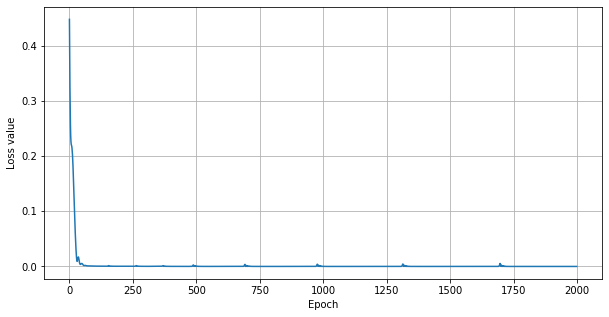

In [23]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [24]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver='rk4'
    ) 

In [25]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [26]:
mse_loss(x_pred_validate, x_validate) 

tensor(0.0491, dtype=torch.float64)

In [27]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

In [28]:
def plot_predictions(n=0):

    print("Validation", n)

    # Create figure
    plt.figure(figsize = (25,5))

    # plot biomass
    plt.subplot(131)
    plt.plot(t_span_validate, 
        x_validate[:, n, 0], 
        color="#069AF3", label = 'Mechanistic model', linewidth = 5)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate, 
        x_validate[:, n, 1], 
        color="#F97306", label = 'Mechanistic model', linewidth = 5)

    # plot ethanol
    plt.subplot(133)
    plt.plot(t_span_validate, 
            x_validate[:, n, 2], 
            color="lightgreen", label = 'Mechanistic model', linewidth = 5)


    # plot biomass
    plt.subplot(131)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 0], label = 'ANN', 
        linestyle="dashed",
        color="#069AF3", linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Biomass", size = 20)
    plt.legend(fontsize = 20)

    # plot substrate
    plt.subplot(132)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 1], label = 'ANN', 
        linestyle="dashed",
        color='#F97306', linewidth = 5)
    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Substrate", size = 20)
    plt.legend(fontsize = 20)

    # plot ethanol
    plt.subplot(133)
    plt.plot(
        t_span_validate,
        x_pred_validate[:, n, 2], label = 'ANN', 
        linestyle="dashed",
        color="lightgreen", linewidth = 5)

    plt.grid()
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel("Concentration (g/L)", size = 20)
    plt.title("Ethanol", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

Validation 0


<ipython-input-28-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-28-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-28-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

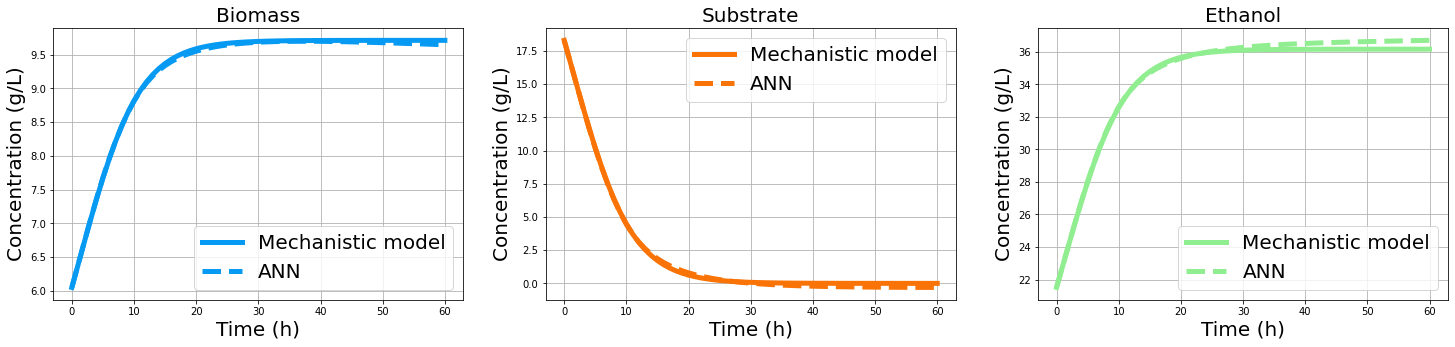

Validation 1


<ipython-input-28-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-28-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-28-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

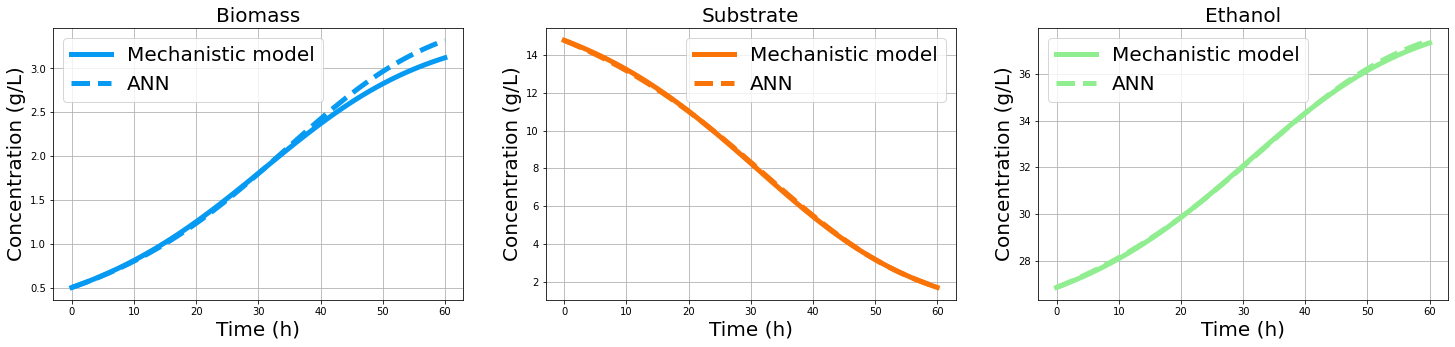

Validation 2


<ipython-input-28-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-28-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-28-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

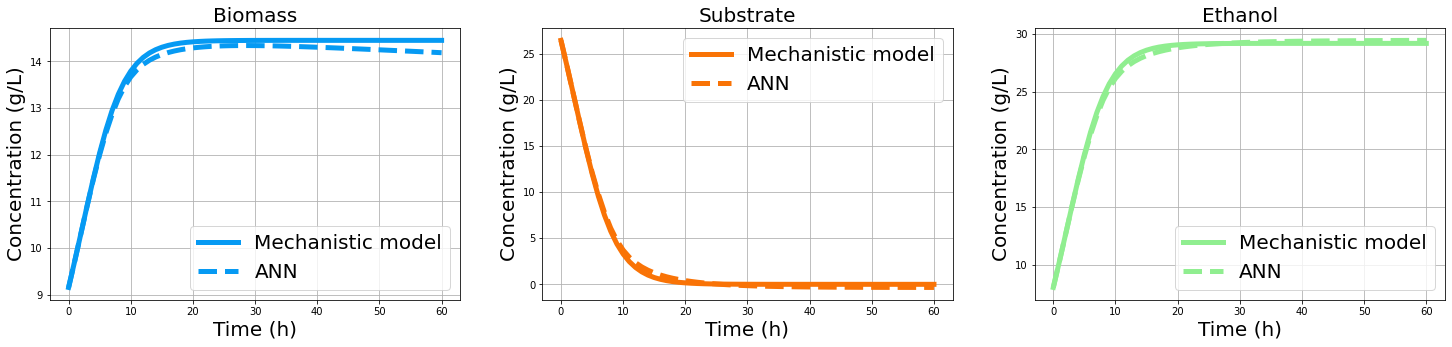

Validation 3


<ipython-input-28-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-28-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-28-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

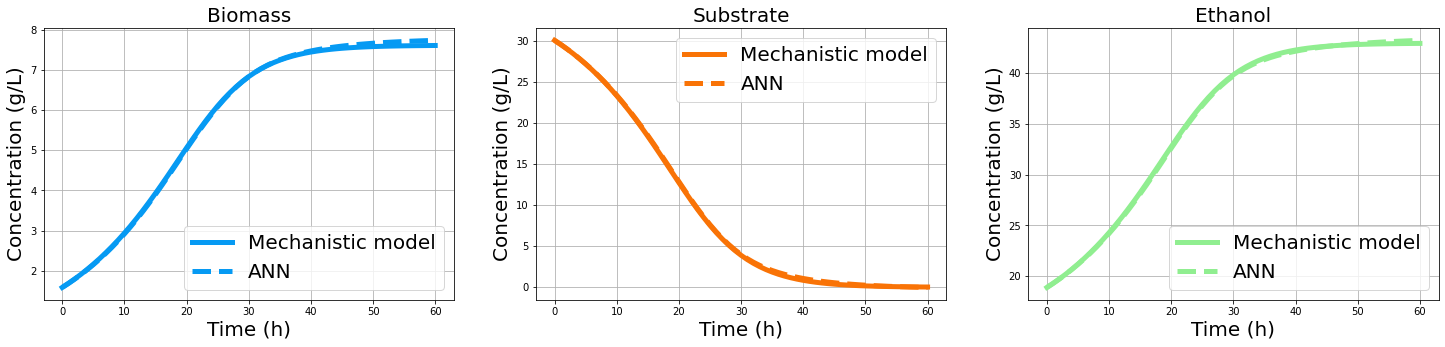

Validation 4


<ipython-input-28-3177a068ea55>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-28-3177a068ea55>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-28-3177a068ea55>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

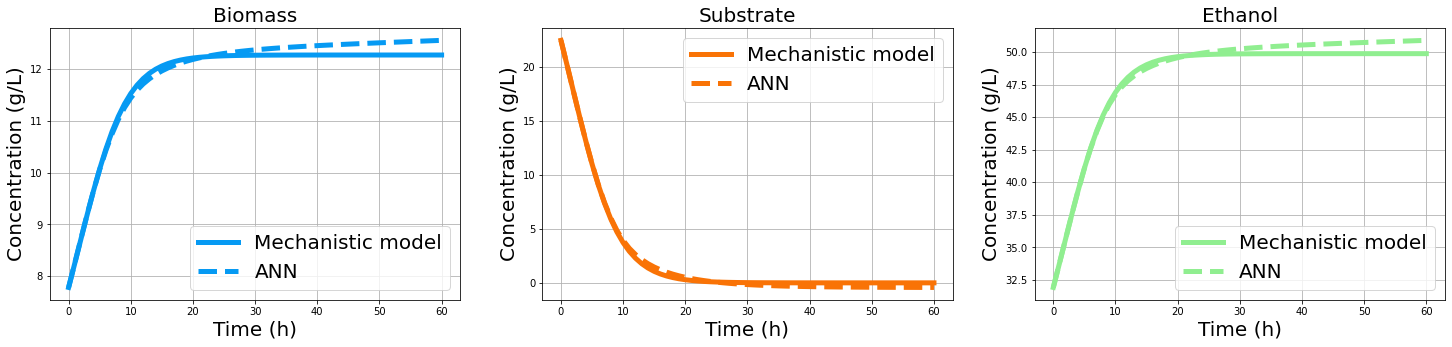

In [29]:
for i in range(5):
    plot_predictions(i)